In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df = pd.read_csv('/Users/jacobcole/Downloads/Paintings - Sheet1.csv')

In [51]:
df.head()

,Order,Image?,Vin,Lot,Category,Short Description,Long Description,Low,High
0,1,NaN,2054-023,269,Modern,"Mary Ann Strandell, ""Harlequin I & ll"", 1999, ...","Mary Ann Strandell, ""Harlequin I & ll"", 1999, ...",400.0,800.0
1,2,NaN,1985-004,185,Modern,"Karen Diesner, Lithograph, Morning fix","Karen Diesner, Lithograph, Morning fix. Titled...",100.0,150.0
2,3,NaN,2054-022,268,Modern,"Mary Ann Strandell, Black and white, Ink on pa...","Mary Ann Strandell, Black and white, Ink on pa...",200.0,400.0
3,4,NaN,2054-020,266,Modern,"Mary Ann Strandell, ""Cliff Dwelling"", 2006, Oi...","Mary Ann Strandell, ""Cliff Dwelling"", 2006, Oi...",60.0,80.0
4,5,NaN,2054-008,254,Modern,"Chris Gentile, I've Just Seen the Rock of Ages...","Chris Gentile, ""I've Just Seen the Rock of Age...",300.0,500.0


In [52]:
df['Mean Price'] = df.apply(lambda row: np.mean([row['Low'], row['High']]), axis=1)

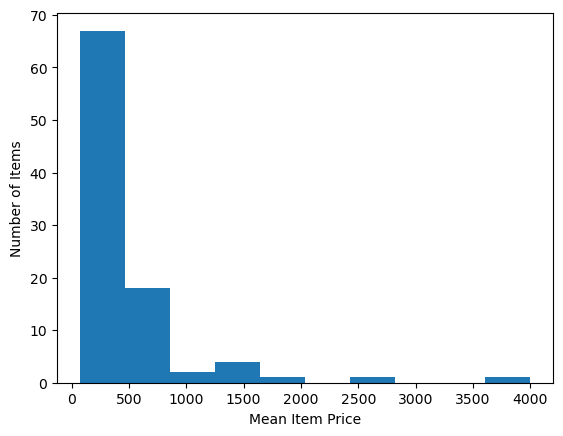

In [53]:
plt.hist(data = df, x = 'Mean Price')
plt.xlabel('Mean Item Price')
plt.ylabel('Number of Items')
plt.show()

# Let's look closer by adjusting the bins #

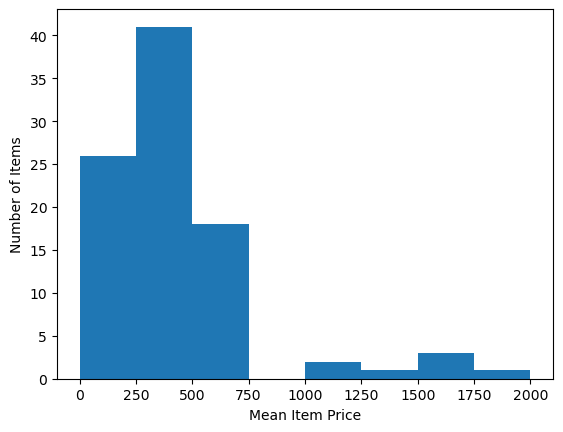

In [54]:
plt.hist(data = df, x = 'Mean Price',bins = [0,250,500,750,1000,1250,1500,1750,2000])
plt.xlabel('Mean Item Price')
plt.ylabel('Number of Items')
plt.show()

<AxesSubplot:xlabel='Mean Price', ylabel='Category'>

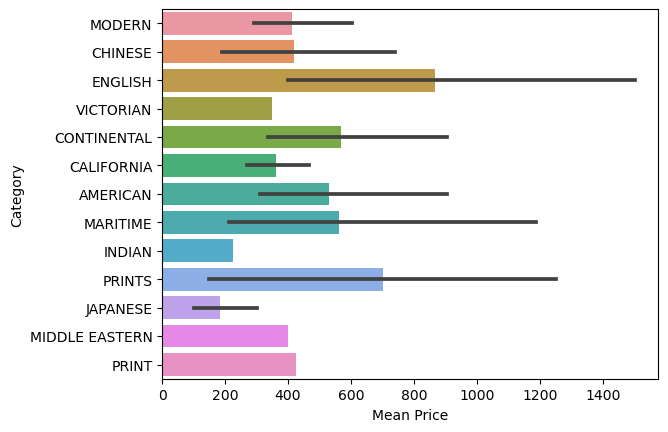

In [55]:
import seaborn as sns
df['Category'] = df['Category'].str.upper()

sns.barplot(data = df, y='Category',x = 'Mean Price')

## Now, let's create a model to predict painting prices ##

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [57]:
class HandleMissing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Long Description'] = X['Long Description'].fillna('missing')
        X['Category'] = X['Category'].fillna('missing')
        return X

In [58]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        # Extract the data as a Series
        series_data = data_dict[self.key]
        
        # Convert the Series to a list of strings
        list_data = series_data.astype(str).tolist()
        
        # Reshape the list to a 2D array
        reshaped_data = [[item] for item in list_data]
        
        return reshaped_data

In [59]:
class ReshapeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convert 2D array to 1D list of strings
        return [item[0] for item in X]


In [74]:
from sklearn.preprocessing import StandardScaler

df['Mean Price'] = df.groupby('Category')['Mean Price'].transform(lambda x: x.fillna(x.median()))
df['Mean Price'] = df['Mean Price'].transform(lambda x: x.fillna(x.median()))

class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        return X[[self.columns]]  # Use double brackets to ensure a DataFrame is returned

    def fit(self, X, y=None, **fit_params):
        return self

# Define the pipelines
categorical_pipe = Pipeline([
    ('selector', SelectColumnsTransformer(columns='Category')),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

text_pipe = Pipeline([
    ('selector', SelectColumnsTransformer(columns='Long Description')),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('reshaper', ReshapeTransformer()),
    ('tfidf', TfidfVectorizer(stop_words='english'))
])

preprocessor = FeatureUnion(transformer_list=[
    ('categorical', categorical_pipe),
    ('text', text_pipe)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', Ridge())
])

# Define the hyperparameters and their possible values
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 49 candidates, totalling 245 fits


In [75]:
result = pd.merge(left=X_test, right=df[['Long Description', 'Low', 'High']], on='Long Description', how='left')

In [76]:
y_pred = best_model.predict(X_test)
result['Mean Estimate'] = y_pred

In [77]:
result

,Category,Long Description,Low,High,Mean Estimate
0,CONTINENTAL,"Two colored English sporting engravings, ""Chel...",150.0,225.0,607.206531
1,AMERICAN,"Caroline Martin, Forest Interior, oil on board...",300.0,500.0,577.734470
2,CONTINENTAL,"Dutch School, Dutch interior scene, woman with...",650.0,800.0,489.469176
3,AMERICAN,"Frank M. Hamilton, ""Reminiscing"", opaque water...",1500.0,2500.0,389.535989
4,CALIFORNIA,"Wm Albert Hamilton Jr (American, 1901-1984) pa...",200.0,400.0,404.032580
5,CONTINENTAL,"Vald. Niellsen, Old Bridge, Copenhagen, oil on...",250.0,350.0,635.196553
6,CALIFORNIA,"Max Heimann, ""The Suitors, (Clowns)"", oil on w...",600.0,800.0,420.429625
7,CALIFORNIA,"Wm Albert Hamilton Jr (American, 1901-1984) pa...",200.0,300.0,429.238918
8,MODERN,"Christy Wydoff, Ocean & Rocks Triptych, 1994, ...",400.0,600.0,563.029293
9,MODERN,"Mary Ann Strandell, ""Harlequin I & ll"", 1999, ...",400.0,800.0,384.293196


# Let's analyze #

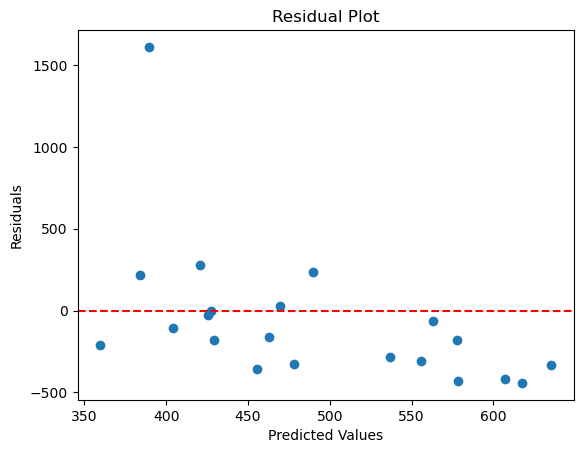

In [78]:
# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

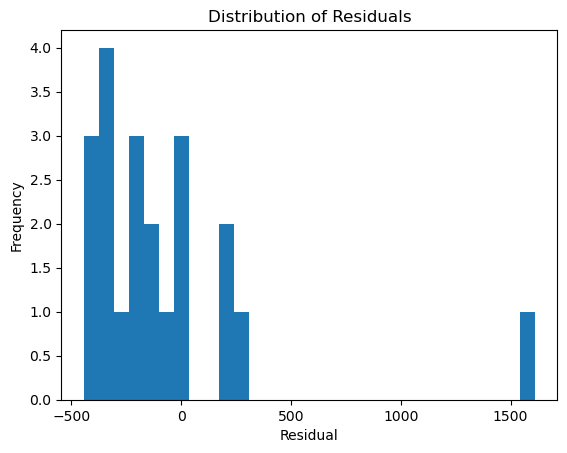

In [79]:
plt.hist(residuals, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()